# Instalación

**Los datos necesarios para realizar la práctica están en una carpeta compartida que se llama `data`, situada en "Shared with me". Para que el cuaderno pueda acceder a ella es necesario crear un link en "My Drive". El link se crea simplemente seleccionando "data", y desde el menu del botón derecho seleccione "Add a shortcut to Drive".**

**Una vez hecho esto, ejecute la siguiente celda. Esta celda montará el directorio de trabajo del cuaderno y verá la carpeta `data` a través del link. Para montar el directorio le pedirá que se registre en "Drive"**.

In [3]:
## Instalación: esta celda monta el directorio de trabajo
if 'google.colab' in str(get_ipython()):
    # Setup colab
    from google.colab import drive
    drive.mount('/drive')
    %cd /drive/My Drive/data
else:
    pass

Mounted at /drive
/drive/.shortcut-targets-by-id/1MHsiAeNCqIWHIkKgK7ggxOaSkemKqWSb/data


# Redes convolucionales I

En este tutorial introducimos un tipo de redes especializadas en procesar imágenes, las redes neuronales convolucionales (**convolutional nerual networks, CNN**). Estas redes se basan en capas que realizan operaciones de convolución en la entrada para obtener la salida. En particular:

- Diseñaremos redes **específicas** con bloques **genéricos** que son reutilizables en diferentes aplicaciones.
- Usaremos redes convolucionales para construir un **clasificador de imágenes**
- Usaremos la **transferencia del aprendizaje** para entrenar un modelo.

En el área de visión por computador, el desafío suele ser diseñar sistemas que "entiendan" una imagen lo suficientemente bien como para resolver los mismos tipos de problemas que el sistema visual humano. Las **redes neuronales convolucionales** (**CNN**) realizan esta tarea de un modo muy eficaz. En general, una red convolucional consta de dos partes: una **base convolucional** y una última **capa densa** que se denomina **cabeza** de la red. En la siguiente figura se representa el esquema de una **CNN** para la clasificación de imágenes.

<center><figure style="padding: 1em;">
<img src="https://i.imgur.com/U0n5xjU.png" width="600" alt="">
<figcaption style="textalign: center; font-style: italic">Esquema típico de una red convolucional: imagen (entrada), base (extracción de características), cabeza (clasificador), clase (salida). </figcaption></figure></center>

La base se utiliza para **extraer las características** de una imagen, está formada principalmente por capas que realizan convoluciones, aunque adicionalmente pueden contener otros tipos de capas. Entendemos por **característica** cualquier tipo de rasgo visual de una imagen, como puede ser una línea, un color, una textura, una forma, un patrón... o alguna combinación de éstas. Por otro lado, la cabeza es la encargada de **determinar la clase** a la que pertenece la imagen, está formada principalmente por capas densas, aunque también puede contener otras capas, como el **dropout**. Un ejemplo del proceso de extracción de características se muestra en la siguiente figura:

<center><figure style="padding: 1em;">
<img src="https://i.imgur.com/UUAafkn.png" width="600" alt="">
<figcaption style="textalign: center; font-style: italic">Ejemplo de extracción de características. </center></figcaption>

Durante el proceso de entrenamiento, la red debe aprender:

- las características más interesantes para extraer, de lo cual se encarga la base.
- la asociación de las características a cada clase, de lo cual se encarga la cabeza.
    
La base de convolución suele extraer características que son útiles para muchas aplicaciones, por esta razón las redes convolucionales rara vez se entrenan desde cero, lo más frecuente es reutilizar la base de un modelo preentrenado. A la base preentrenada se le añade una cabeza nueva, acorde con la tarea que queremos realizar. Es decir, reutilizamos la base de una red que ya ha aprendido a extraer características y le adjuntamos algunas capas nuevas para aprender la tarea determinada por la aplicación final. La reutilización de un modelo preentrenado es una técnica conocida como **transferencia de aprendizaje** (o **transfer learning**). 

<center>
<img src="https://imgur.com/E49fsmV.png" width="400" alt="">
<figcaption style="textalign: center; font-style: italic"><center>Ejemplo de reutilización de un modelo.
</center></figcaption></center>

En primer lugar vamos a diseñar un **clasificador de imágenes**, el cual permite determinar el contenido de una imagen. Sin embargo, aunque nos centramos en la clasificación, los conceptos son comunes en cualquier tipo de problema de visión por computador, como la segmentación, reconocimiento, etc.  A continuación presentamos un sistema capaz de diferenciar entre un *coche* y una *camioneta*. Para ello vamos a utilizar un conjunto de datos que contiene alrededor de 10.000 fotos de vehículos, de los cuales aproximadamente la mitad son *coches* y la otra mitad son *camionetas*. Dado que la cabeza suele estar formada por unas pocas capas densas, y que la base ya está pre-entrenada, se pueden crear clasificadores muy precisos a partir de pocos datos, relativamente. 

# Clasificador de imágenes

En este ejemplo vamos a realizar todos los pasos necesarios para configurar una red convolucional, la cual será entrenada mediante **transferencia de aprendizaje** a partir de una base convolucional estándar.

## Paso 1 - Carga de datos
Las siguientes celdas importarán las librerías necesarias:

In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import VGG16
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore") # to clean up output cells
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib.image as img
# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=16, titlepad=10)
plt.rc('image', cmap='magma')

A continuación cargamos los datos, tenemos un conjunto de datos de entrenamiento llamado `ds_train` y un conjunto de validación llamado `ds_valid`. Además, añadimos algunas operaciones de preprocesado, acondicionamiento de los datos y configuración del flujo de datos a la red, esto último se llama técnicamente **data pipeline**.

In [5]:
# Reproducibility
def set_seed(seed=31415):
    np.random.seed(seed)
    tf.random.set_seed(seed)
set_seed(31415)

# Load training and validation sets
ds_train_ = image_dataset_from_directory(
    'data_m3/datasets/car_or_truck/train',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=True,
)
ds_valid_ = image_dataset_from_directory(
    'data_m3/datasets/car_or_truck/valid',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=False,
)
# Data Pipeline
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE
ds_train = (
    ds_train_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
ds_valid = (
    ds_valid_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

Found 5117 files belonging to 2 classes.
Found 5061 files belonging to 2 classes.


Veamos algunos ejemplos del conjunto de entrenamiento, donde `0` corresponde a la clase `coche` y `1` corresponde a la clase `camioneta`.

<blockquote style="margin-right:auto; margin-left:auto; background-color: #ebf9ff; padding: 1em; margin:24px;">
    <strong>Nota:</strong><br>
Siguiendo la nomenclatura norteamericana, en la base de datos `camioneta` se incluyen todos los vehículos que no son turismos, es decir, todoterrenos, sub, monovolumen, pickup,... Es justo mencionar que en ocasiones la diferencia no es sencilla, incluso para el ojo humano.
</blockquote>

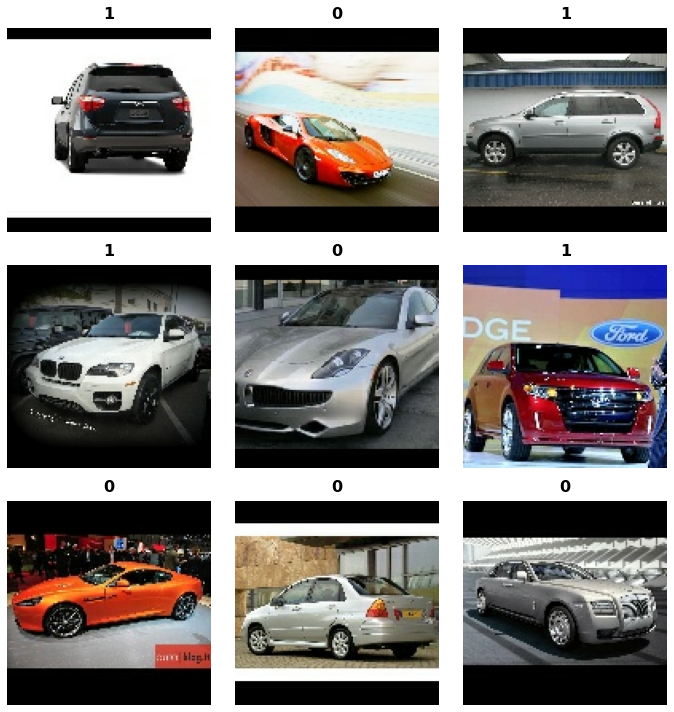

In [6]:
plt.figure(figsize=(10, 10))
for images, labels in ds_train_.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

## Paso 2 - Base preentrenada

La base de datos más utilizada para el preentrenamiento es [*ImageNet*](http://image-net.org/about-overview), un conjunto de **15 millones** de imágenes, con multitud de categorías de imágenes naturales. *Keras* incluye una variedad de modelos preentrenados sobre *ImageNet* en su módulo de[`aplicaciones`](https://www.tensorflow.org/api_docs/python/tf/keras/applications). El modelo preentrenado de la red que utilizamos se llama **VGG16**, la cual se trata de una red convolucional clásica con 16 capas, muy utilizada con *ImageNet* en multitud de aplicaciones. 

In [7]:
pretrained_base = VGG16(include_top=False,
                        weights='imagenet',
                        input_shape=[128, 128, 3])
pretrained_base.trainable = False

58889256/58889256 [==============================] - 3s 0us/step


## Paso 3 - Configuración de la cabeza

La base convolucional suele trabajar con la estructura bidimensional de las imágenes, esto le permite utilizar la correlación espacial de los píxeles y la extracción eficaz de las características. Sin embargo, la cabeza de la red suele agrupar todas las características en un vector unidimensional, a partir del cual se establece la clasificación. A continuación adjuntamos la cabeza del clasificador. En primer lugar, la capa `Flatten` transforma las salidas bidimensionales de la base en una entrada unidimensional para la clasificación. El clasificador conecta y agrupa las características mediante una capa `Dense` con 6 neuronas, y finalmente concentramos toda la información en una capa de una única neurona. Esta última neurona tiene una función de activación `sigmoide`, encargada de transformar la salida en un valor de probabilidad, dentro del intervalo `[0,1]`. El valor obtenido lo asociamos con la probabilidad de obtener la etiqueta `Truck`, por lo que si el valor es mayor que `0.5`, la etiqueta será `Truck`, y si es menor será `Car`. En la siguiente celda se configura la red neuronal.

In [8]:
model = keras.Sequential([
    pretrained_base,
    layers.Flatten(),
    layers.Dense(6, activation='relu'),
    layers.Dense(1, activation='sigmoid'),
])

En la siguiente celda se visualiza la estructura de la cabeza de la red y el número de parámetros total. Obsérvese que la red tiene más de 14 millones de parámetros!!!, de los cuales solo entrenamos 49.165.

In [9]:
model.build(input_shape=[None, 128, 128,3])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 6)                 49158     
                                                                 
 dense_1 (Dense)             (None, 1)                 7         
                                                                 
Total params: 14,763,853
Trainable params: 49,165
Non-trainable params: 14,714,688
_________________________________________________________________


## Paso 4 - Entrenamiento

Por último, en la siguiente celda realizamos el entrenamiento del modelo. Como este es un problema de clasificación binaria, usaremos las versiones binarias de `crossentropy` y `accuracy`. El optimizador `adam` generalmente funciona bien, así que lo mantenemos. 

Este modelo puede tardar unos 30 minutos en realizar el entrenamiento, por eso se ha comentado. No es necesario entrenar el modelo, puede analizar el resultado que ha sido previamente realizado y guardado.

In [15]:

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)

out = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=20,
    verbose=1,
)


Epoch 1/20
 3/80 [>.............................] - ETA: 11:23 - loss: 1.0202 - binary_accuracy: 0.5156

KeyboardInterrupt: ignored

A continuación examinamos los gráficos de pérdidas y las métricas de precisión. Si se ha entrenado el modelo descomente y ejecute la siguiente celda.

In [14]:

history_df = pd.DataFrame(out.history)
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15, 5))
history_df.loc[:, ['loss', 'val_loss']].plot(xlabel='Épocas', ax=ax1, grid=True)
ax1.set(xlabel='Épocas', ylabel='Pérdidas')
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot(xlabel='Épocas',ax=ax2, grid=True);
ax2.set(xlabel='Épocas', ylabel='Precisión')
# plt.savefig('data_m3/figs/training-vgg16.png')

print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}")\
      .format(history_df['val_loss'].min(), 
              history_df['val_binary_accuracy'].max()))


NameError: ignored

Si no se ha realizado el entrenamiento y no se visualizan las gráficas de pérdidas de la celda anterior, puede observarlas descomentando el código de la siguiente celda.

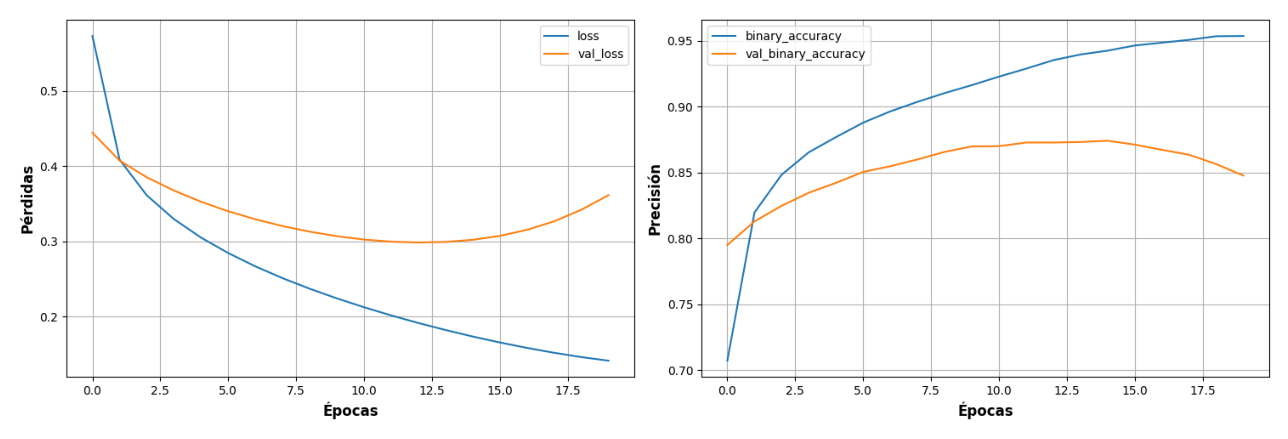

In [16]:
im = img.imread('data_m3/figs/training-vgg16.png')
plt.figure(figsize=(18, 10))
plt.imshow(im)
plt.axis("off");

Hemos conseguido una precisión en las predicciones de un 86%. Como se puede observar en ambas gráficas, tenemos un **overfitting** muy marcado, ya que la red tiene mucha capacidad de aprendizaje. El modelo está aprendiendo cada vez más el conjunto de entrenamiento y el ruido que contiene, y como consecuencia, las gráficas de pérdidas en el conjunto de entrenamiento respecto del conjunto de validación se separan.

# Conclusiones 

Hemos aprendido la estructura general de una red convolucional: una **base** convolucional que realiza la extracción de características y una **cabeza** que trabaja con el mapa de características de la base. Ésta última depende de la aplicación concreta. Una base entrenada se puede reutilizar para multitud de aplicaciones mediante **transfer learning**, lo cual facilita el entrenamiento con un conjunto de datos reducido y mejora los resultados, si lo comparamos con un entrenamienco completo de toda la red. Se ha realizado paso a paso el proceso de diseño, implementación y entrenamiento de un clasificador de imágenes.